In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans  # Using MiniBatchKMeans instead
from sklearn.metrics import davies_bouldin_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
customers_df = pd.read_csv('../data/raw/Customers.csv')
transactions_df = pd.read_csv('../data/raw/Transactions.csv')

# Create features
def create_customer_features():
    # Aggregate transactions
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean'],
        'TransactionID': 'count'
    }).reset_index()
    
    # Flatten column names
    transaction_features.columns = [
        'CustomerID', 'total_spend', 'avg_transaction_value',
        'total_quantity', 'avg_quantity', 'transaction_count'
    ]
    
    return transaction_features

# Create and scale features
customer_features = create_customer_features()
feature_columns = ['total_spend', 'avg_transaction_value', 'transaction_count']

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(customer_features[feature_columns])

In [13]:
from sklearn.cluster import AgglomerativeClustering  # Add import here as well

def perform_clustering(X, n_clusters):
    """Perform hierarchical clustering"""
    try:
        # Create clustering model
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        
        # Fit and get labels
        labels = clustering.fit_predict(X)
        
        # Calculate metrics
        db_index = davies_bouldin_score(X, labels)
        silhouette = silhouette_score(X, labels)
        
        return labels, db_index, silhouette
    
    except Exception as e:
        print(f"Error in clustering: {str(e)}")
        return None, None, None

# Try different numbers of clusters
print("\nEvaluating different numbers of clusters...")
results = []

for n_clusters in range(2, 11):
    print(f"\nTrying {n_clusters} clusters...")
    labels, db_index, silhouette = perform_clustering(X, n_clusters)
    
    if labels is not None:
        results.append({
            'n_clusters': n_clusters,
            'db_index': db_index,
            'silhouette': silhouette
        })
        print(f"DB Index: {db_index:.4f}")
        print(f"Silhouette Score: {silhouette:.4f}")
    else:
        print(f"Skipping {n_clusters} clusters due to error")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

if len(results_df) > 0:
    # Find optimal number of clusters
    optimal_clusters = results_df.loc[results_df['db_index'].idxmin(), 'n_clusters']
    best_db_score = results_df['db_index'].min()
    
    print(f"\nOptimal number of clusters: {optimal_clusters}")
    print(f"Best DB Index: {best_db_score:.4f}")
    
    # Perform final clustering with optimal number
    final_labels, final_db, final_silhouette = perform_clustering(X, int(optimal_clusters))
    customer_features['Cluster'] = final_labels


Evaluating different numbers of clusters...

Trying 2 clusters...
DB Index: 1.0134
Silhouette Score: 0.3851

Trying 3 clusters...
DB Index: 0.9673
Silhouette Score: 0.3419

Trying 4 clusters...
DB Index: 1.0660
Silhouette Score: 0.3024

Trying 5 clusters...
DB Index: 0.8851
Silhouette Score: 0.3427

Trying 6 clusters...
DB Index: 0.8650
Silhouette Score: 0.3032

Trying 7 clusters...
DB Index: 0.8838
Silhouette Score: 0.3179

Trying 8 clusters...
DB Index: 0.8714
Silhouette Score: 0.3188

Trying 9 clusters...
DB Index: 0.9462
Silhouette Score: 0.3270

Trying 10 clusters...
DB Index: 0.8405
Silhouette Score: 0.3374

Optimal number of clusters: 10
Best DB Index: 0.8405


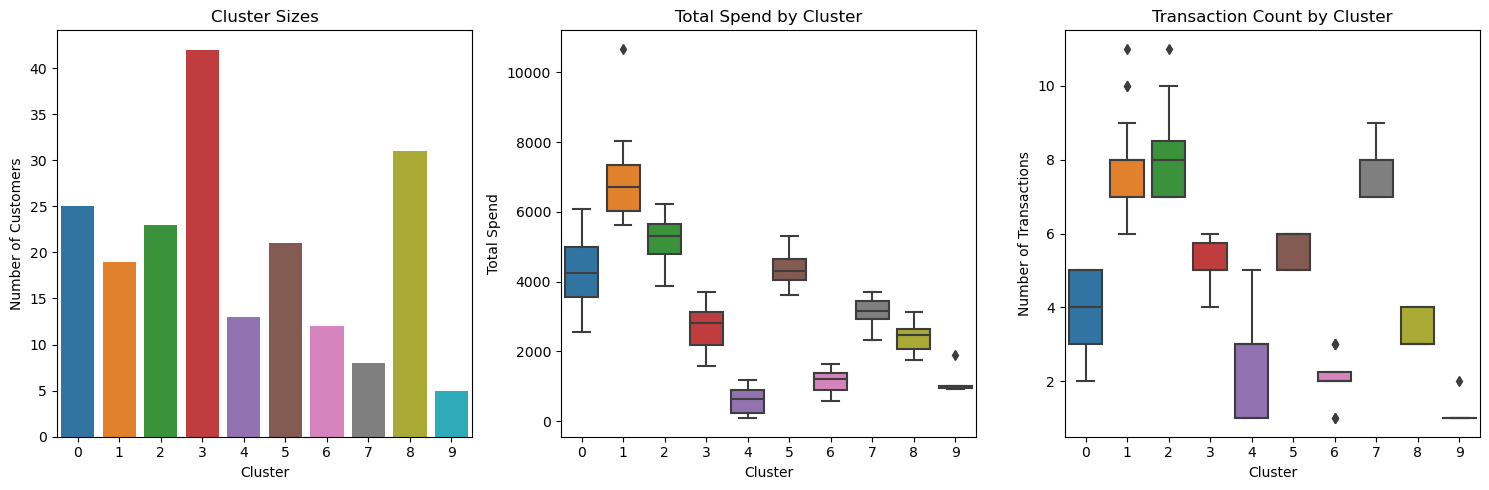

In [16]:
plt.figure(figsize=(15, 5))
    
    # Plot 1: Cluster sizes
plt.subplot(1, 3, 1)
sns.countplot(data=customer_features, x='Cluster')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
    
    # Plot 2: Total spend by cluster
plt.subplot(1, 3, 2)
sns.boxplot(data=customer_features, x='Cluster', y='total_spend')
plt.title('Total Spend by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spend')
    
    # Plot 3: Transaction count by cluster
plt.subplot(1, 3, 3)
sns.boxplot(data=customer_features, x='Cluster', y='transaction_count')
plt.title('Transaction Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Transactions')
    
plt.tight_layout()
plt.show()

In [18]:
print("\nCluster Characteristics:")
for cluster in range(int(optimal_clusters)):
        cluster_data = customer_features[customer_features['Cluster'] == cluster]
        print(f"\nCluster {cluster} ({len(cluster_data)} customers):")
        for col in feature_columns:
            mean_val = cluster_data[col].mean()
            std_val = cluster_data[col].std()
            print(f"{col}: {mean_val:.2f} ± {std_val:.2f}")


Cluster Characteristics:

Cluster 0 (25 customers):
total_spend: 4327.30 ± 962.65
avg_transaction_value: 1082.07 ± 124.66
transaction_count: 4.04 ± 0.93

Cluster 1 (19 customers):
total_spend: 6869.27 ± 1170.03
avg_transaction_value: 875.32 ± 101.28
transaction_count: 7.89 ± 1.29

Cluster 2 (23 customers):
total_spend: 5161.41 ± 664.55
avg_transaction_value: 641.70 ± 92.87
transaction_count: 8.13 ± 1.10

Cluster 3 (42 customers):
total_spend: 2701.10 ± 583.25
avg_transaction_value: 531.18 ± 83.59
transaction_count: 5.07 ± 0.68

Cluster 4 (13 customers):
total_spend: 590.32 ± 400.43
avg_transaction_value: 237.06 ± 84.77
transaction_count: 2.38 ± 1.45

Cluster 5 (21 customers):
total_spend: 4362.56 ± 474.89
avg_transaction_value: 777.29 ± 60.60
transaction_count: 5.62 ± 0.50

Cluster 6 (12 customers):
total_spend: 1131.92 ± 339.88
avg_transaction_value: 557.26 ± 110.84
transaction_count: 2.08 ± 0.67

Cluster 7 (8 customers):
total_spend: 3144.77 ± 448.53
avg_transaction_value: 410.05 ± 

In [20]:
results_df = pd.DataFrame(results)
optimal_clusters = results_df.loc[results_df['db_index'].idxmin(), 'n_clusters']
best_db_score = results_df['db_index'].min()

print(f"\nOptimal number of clusters: {optimal_clusters}")
print(f"Best DB Index: {best_db_score:.4f}")


Optimal number of clusters: 10
Best DB Index: 0.8405


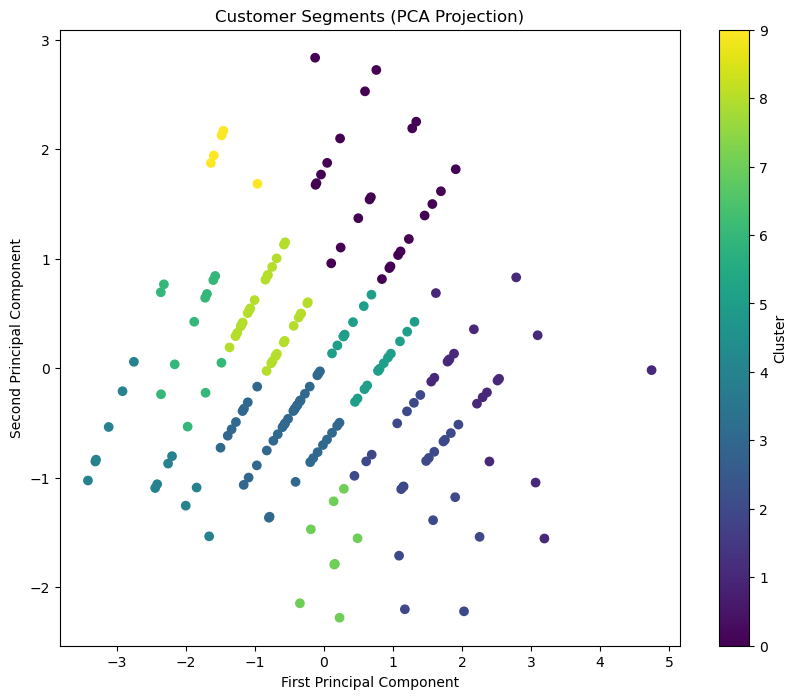

In [21]:
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=customer_features['Cluster'], 
                     cmap='viridis')
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [23]:
final_labels, final_db, final_silhouette = perform_clustering(X, int(optimal_clusters))
customer_features['Cluster'] = final_labels

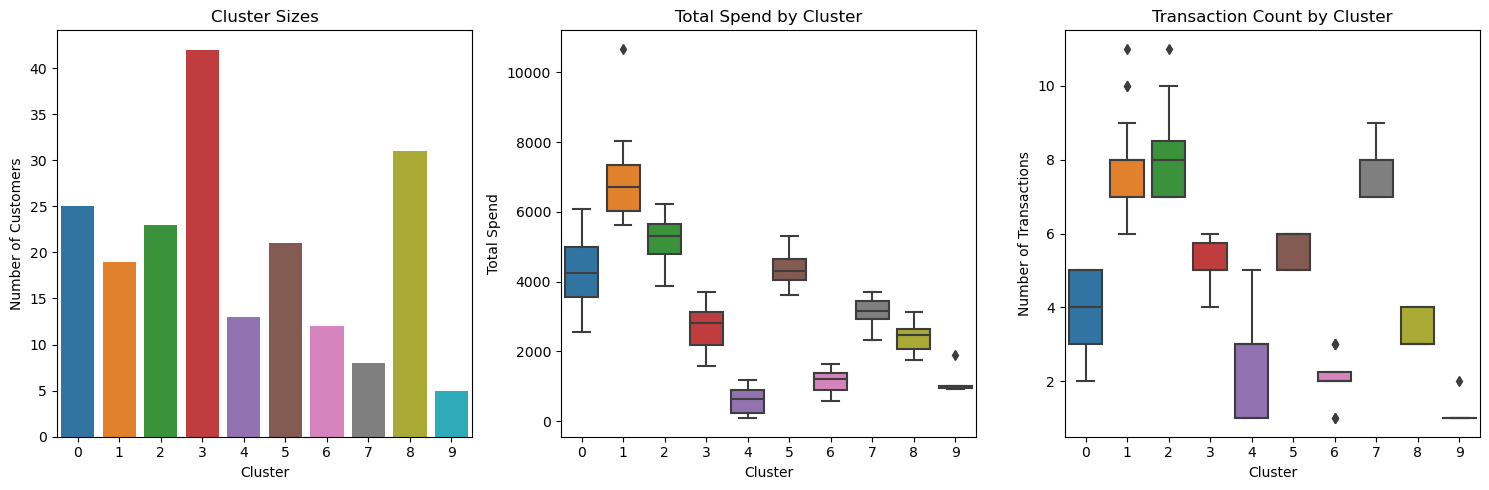

In [24]:
plt.figure(figsize=(15, 5))

# Cluster sizes
plt.subplot(1, 3, 1)
sns.countplot(data=customer_features, x='Cluster')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')

# Total spend by cluster
plt.subplot(1, 3, 2)
sns.boxplot(data=customer_features, x='Cluster', y='total_spend')
plt.title('Total Spend by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spend')

# Transaction count by cluster
plt.subplot(1, 3, 3)
sns.boxplot(data=customer_features, x='Cluster', y='transaction_count')
plt.title('Transaction Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Transactions')

plt.tight_layout()
plt.show()


In [25]:
print("\nCluster Characteristics:")
for cluster in range(int(optimal_clusters)):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} customers):")
    for col in feature_columns:
        mean_val = cluster_data[col].mean()
        std_val = cluster_data[col].std()
        print(f"{col}: {mean_val:.2f} ± {std_val:.2f}")


Cluster Characteristics:

Cluster 0 (25 customers):
total_spend: 4327.30 ± 962.65
avg_transaction_value: 1082.07 ± 124.66
transaction_count: 4.04 ± 0.93

Cluster 1 (19 customers):
total_spend: 6869.27 ± 1170.03
avg_transaction_value: 875.32 ± 101.28
transaction_count: 7.89 ± 1.29

Cluster 2 (23 customers):
total_spend: 5161.41 ± 664.55
avg_transaction_value: 641.70 ± 92.87
transaction_count: 8.13 ± 1.10

Cluster 3 (42 customers):
total_spend: 2701.10 ± 583.25
avg_transaction_value: 531.18 ± 83.59
transaction_count: 5.07 ± 0.68

Cluster 4 (13 customers):
total_spend: 590.32 ± 400.43
avg_transaction_value: 237.06 ± 84.77
transaction_count: 2.38 ± 1.45

Cluster 5 (21 customers):
total_spend: 4362.56 ± 474.89
avg_transaction_value: 777.29 ± 60.60
transaction_count: 5.62 ± 0.50

Cluster 6 (12 customers):
total_spend: 1131.92 ± 339.88
avg_transaction_value: 557.26 ± 110.84
transaction_count: 2.08 ± 0.67

Cluster 7 (8 customers):
total_spend: 3144.77 ± 448.53
avg_transaction_value: 410.05 ± 

In [26]:
output_df = pd.DataFrame({
    'CustomerID': customer_features['CustomerID'],
    'Cluster': customer_features['Cluster']
})
output_df.to_csv('../output/FirstName_LastName_Clustering_Results.csv', index=False)

# Save metrics
metrics_df = pd.DataFrame({
    'Metric': ['Number of Clusters', 'Davies-Bouldin Index', 'Silhouette Score'],
    'Value': [optimal_clusters, final_db, final_silhouette]
})
metrics_df.to_csv('../output/FirstName_LastName_Clustering_Metrics.csv', index=False)

print("\nClustering analysis completed and results saved!")


Clustering analysis completed and results saved!
